### Setup

In [7]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
# import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Sigmoid, Dropout
from train import _compute_metrics, train_epoch, eval_epoch, train_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import matplotlib.pyplot as plt

from train import train_model
import pickle


In [8]:
project_path = Path(Path.cwd()).parent.parent

In [9]:
SEED = 7777

### Load Data

In [10]:
cancer_detection_path = project_path / "data/inputs/Lung Cancer Dataset.csv"
df_detection = pd.read_csv(cancer_detection_path)

df_detection.columns = [x for x in df_detection.columns.str.lower().str.replace(" ", "_")]

df_detection.head(10)

,age,gender,smoking,finger_discoloration,mental_stress,exposure_to_pollution,long_term_illness,energy_level,immune_weakness,breathing_issue,alcohol_consumption,throat_discomfort,oxygen_saturation,chest_tightness,family_history,smoking_family_history,stress_immune,pulmonary_disease
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES
5,37,1,1,1,1,1,1,57.684285,0,1,1,1,94.057151,1,0,0,0,YES
6,50,0,1,1,1,0,1,52.647022,1,1,1,0,96.773598,0,0,0,1,NO
7,68,0,1,1,1,0,1,53.306451,0,0,0,1,95.019018,0,0,0,0,NO
8,48,0,1,1,0,1,1,64.272789,1,1,0,1,98.539379,1,0,0,0,YES
9,52,0,0,0,1,1,1,58.319319,0,1,0,1,96.055097,0,0,0,0,NO


In [11]:
df_detection.shape

(5000, 18)

### Preprocessing

In [13]:
# Convert label column to numerical values
label_map_dict = {
    'NO': 0,
    'YES': 1
}

df_detection['pulmonary_disease'] = df_detection['pulmonary_disease'].map(label_map_dict)

In [14]:
# Convert binary columns to categorical
binary_columns = [
    'gender',
    'smoking',
    'finger_discoloration',
    'mental_stress',
    'exposure_to_pollution',
    'long_term_illness',
    'immune_weakness',
    'breathing_issue',
    'alcohol_consumption',
    'throat_discomfort',
    'chest_tightness',
    'family_history',
    'smoking_family_history',
    'stress_immune',
    'pulmonary_disease'
]

df_detection[binary_columns] = df_detection[binary_columns].astype('category')

In [15]:
X = df_detection.drop(columns=['pulmonary_disease']).values
y = df_detection['pulmonary_disease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train)

In [16]:
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (3612, 17)
Validation set shape: (638, 17)
Test set shape: (750, 17)


In [17]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([57.37015504,  0.49612403,  0.66196013,  0.60354374,  0.54512735,
         0.51522702,  0.43992248, 54.99256295,  0.39451827,  0.79983389,
         0.35022148,  0.69988926, 94.9913959 ,  0.6013289 ,  0.303433  ,
         0.20265781,  0.21179402]),
 array([15.83079571,  0.49998498,  0.47304219,  0.48916121,  0.49795936,
         0.49976808,  0.49637757,  7.84740972,  0.48874697,  0.40012453,
         0.4770392 ,  0.45830589,  1.49321387,  0.48962481,  0.4597406 ,
         0.40197963,  0.40857963]))

In [18]:
with open("ga_results.pkl", "rb") as f:
    ga_results = pickle.load(f)

In [19]:
best_feature_set = ga_results['best_individual']
best_feature_mask = np.array(best_feature_set, dtype=bool)
print(best_feature_set)
print(best_feature_mask)

[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]
[ True False  True  True False  True False  True  True  True False  True
 False False  True  True  True]


In [20]:
# df_detection_x = df_detection.drop(columns=['pulmonary_disease'])
# df_detection_x.columns[best_feature_mask]

In [21]:
# deleted_columns = df_detection_x.columns[~best_feature_mask]
# deleted_columns

In [22]:
X_train = X_train[:,best_feature_mask]
X_val = X_val[:,best_feature_mask]
X_test = X_test[:,best_feature_mask]

In [23]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### GA-FS performance

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
epochs = 300

In [33]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

mlp = Sequential(
    Linear(11, 64),
    ReLU(),
    Dropout(0.4),
    Linear(64, 32),
    ReLU(),
    Dropout(0.4),
    Linear(32, 16),
    ReLU(),
    Dropout(0.1),
    Linear(16, 2)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0005, weight_decay=1e-3)



train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [20]:
results = train_model(mlp, train_loader, val_loader, criterion, optimizer, device)

Starting training for 300 epochs with patience=75
Epoch   1/300 | Train: Loss 0.6826 Acc 57.12% F1 0.5923 AUROC 0.6444 | Val: Loss 0.6418 Acc 81.03% F1 0.7218 AUROC 0.8864
Epoch  10/300 | Train: Loss 0.3474 Acc 88.21% F1 0.8551 AUROC 0.9197 | Val: Loss 0.2708 Acc 91.69% F1 0.8983 AUROC 0.9445
Epoch  20/300 | Train: Loss 0.3252 Acc 89.81% F1 0.8742 AUROC 0.9233 | Val: Loss 0.2568 Acc 92.48% F1 0.9077 AUROC 0.9451
Epoch  30/300 | Train: Loss 0.3117 Acc 89.95% F1 0.8759 AUROC 0.9291 | Val: Loss 0.2474 Acc 92.79% F1 0.9112 AUROC 0.9453
Epoch  40/300 | Train: Loss 0.3000 Acc 90.31% F1 0.8807 AUROC 0.9321 | Val: Loss 0.2415 Acc 93.10% F1 0.9141 AUROC 0.9472
Epoch  50/300 | Train: Loss 0.3016 Acc 90.42% F1 0.8813 AUROC 0.9279 | Val: Loss 0.2381 Acc 93.10% F1 0.9151 AUROC 0.9463
Epoch  60/300 | Train: Loss 0.2959 Acc 91.00% F1 0.8892 AUROC 0.9271 | Val: Loss 0.2346 Acc 93.57% F1 0.9204 AUROC 0.9468
Epoch  70/300 | Train: Loss 0.2940 Acc 90.70% F1 0.8851 AUROC 0.9285 | Val: Loss 0.2345 Acc 93.5

In [23]:
results

{'history': {'train_loss': [0.6826017606562026,
   0.5845653975788805,
   0.43680377916772234,
   0.38684230247473267,
   0.37923739137641616,
   0.37093565887787017,
   0.3531559946331075,
   0.35767152423610454,
   0.34649571172422744,
   0.3474013962156881,
   0.3417155562445175,
   0.3404845670608191,
   0.34186668814482746,
   0.34758039493761456,
   0.33622041202726816,
   0.3282901802464313,
   0.33028922600471566,
   0.3237342142385502,
   0.325867342674983,
   0.325176298684324,
   0.3262396673295453,
   0.32826001834895785,
   0.31625809862896187,
   0.3206654550427218,
   0.3171541178774332,
   0.3099159032502444,
   0.31297693517913056,
   0.3114269238505781,
   0.31101381501486136,
   0.3116893006255592,
   0.3120533089470098,
   0.3112445581592991,
   0.30589934716523026,
   0.30903150015825187,
   0.3121651195542493,
   0.30856863730241557,
   0.31095457813008415,
   0.3095104293041715,
   0.30186246125933075,
   0.30002068364342976,
   0.3070234376462723,
   0.306702793

In [22]:
# Load best model and evaluate on test set
mlp.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_labels, test_preds, test_probs = eval_epoch(mlp, test_loader, criterion, device)
test_precision, test_recall, test_f1, test_auroc = _compute_metrics(test_labels, test_preds, test_probs)

print(f"\nRESULTADOS DEL CONJUNTO DE PRUEBA (usando el mejor modelo):")
print(f"Pérdida: {test_loss:.4f}, Accuracy: {test_acc:.2f}%, Precision: {test_precision:.4f}, "
      f"Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUROC: {test_auroc:.4f}")


RESULTADOS DEL CONJUNTO DE PRUEBA (usando el mejor modelo):
Pérdida: 0.3057, Accuracy: 90.27%, Precision: 0.8722, Recall: 0.8922, F1: 0.8821, AUROC: 0.9118


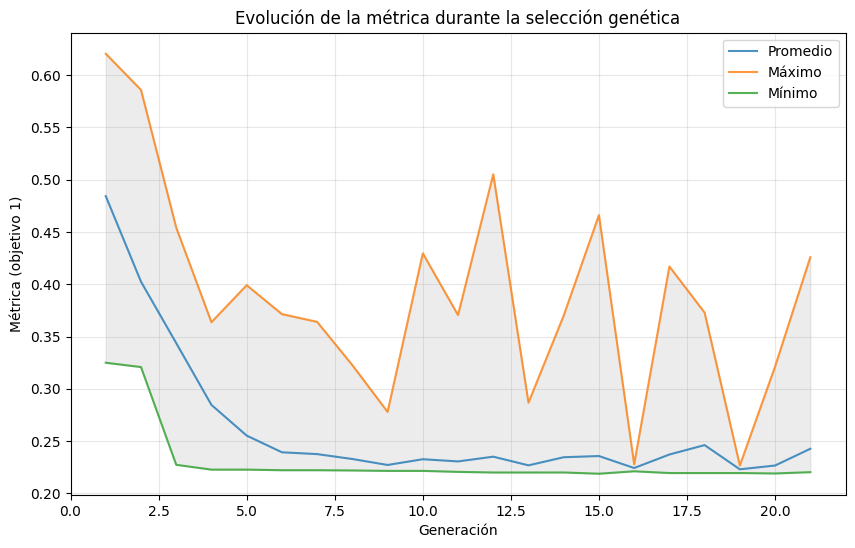

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Example logbook data (replace with your actual ga_results['logbook'])
logbook = ga_results['logbook']

# Extract data
generations = [entry['gen'] + 1 for entry in logbook]
avg_metric = [entry['avg'][0] * -1 for entry in logbook]
min_metric = [entry['min'][0] * -1 for entry in logbook]
max_metric = [entry['max'][0] * -1 for entry in logbook]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(generations, avg_metric, label='Promedio', alpha=0.8)
plt.plot(generations, min_metric, label='Máximo', alpha=0.8)
plt.plot(generations, max_metric, label='Mínimo', alpha=0.8)

# Fill area between min and max
plt.fill_between(generations, min_metric, max_metric, color='gray', alpha=0.15)

plt.xlabel('Generación')
plt.ylabel('Métrica (objetivo 1)')
plt.title('Evolución de la métrica durante la selección genética')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


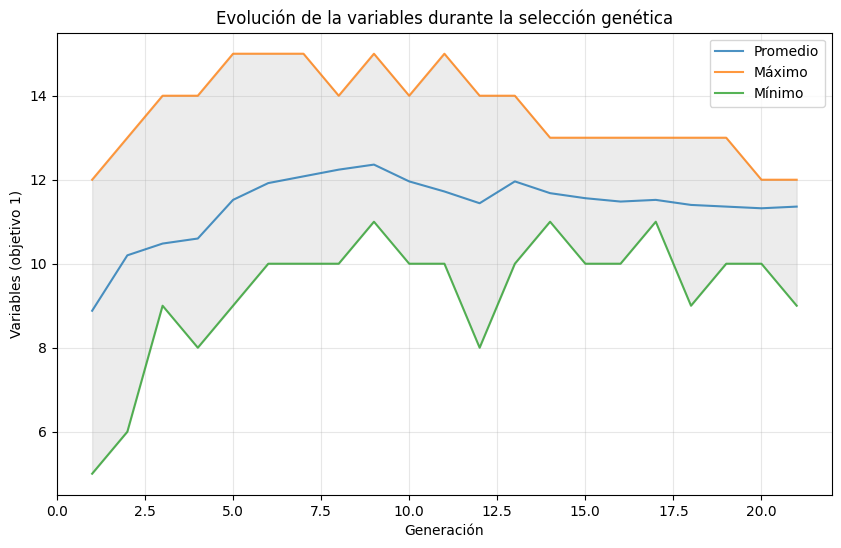

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example logbook data (replace with your actual ga_results['logbook'])
logbook = ga_results['logbook']

# Extract data
generations = [entry['gen'] + 1 for entry in logbook]
avg_metric = [entry['avg'][1]*-1 for entry in logbook]
min_metric = [entry['min'][1]*-1 for entry in logbook]
max_metric = [entry['max'][1]*-1 for entry in logbook]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(generations, avg_metric, label='Promedio', alpha=0.8)
plt.plot(generations, min_metric, label='Máximo', alpha=0.8)
plt.plot(generations, max_metric, label='Mínimo', alpha=0.8)

# Fill area between min and max
plt.fill_between(generations, min_metric, max_metric, color='gray', alpha=0.15)


plt.xlabel('Generación')
plt.ylabel('Variables (objetivo 1)')
plt.title('Evolución de la variables durante la selección genética')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [72]:
min_metric

[np.float64(0.6204894099115952),
 np.float64(0.5858947083494133),
 np.float64(0.45429804743644214),
 np.float64(0.36373661687381587),
 np.float64(0.39915987157896393),
 np.float64(0.371515758172098),
 np.float64(0.3640711867136641),
 np.float64(0.32271097025901174),
 np.float64(0.27800366964459794),
 np.float64(0.4296397142649444),
 np.float64(0.370597881209514),
 np.float64(0.5052659109842067),
 np.float64(0.286791358948875),
 np.float64(0.37013182950244056),
 np.float64(0.46615917368742366),
 np.float64(0.22791857807240143),
 np.float64(0.41702969657216327),
 np.float64(0.3729197140024),
 np.float64(0.2267200736603393),
 np.float64(0.3213746344968443),
 np.float64(0.42597589812308645)]